# Laboratorio 2: CompuAlpes

- Juan Camilo Colmenares - 202011866
- Juan Montealegre - 202012723
- David Gonzales - 201815834

CompuAlpes es una reconocida tienda minorista que vende computadores portátiles de diferentes fabricantes y especificaciones técnicas. Con el auge de la tecnología y el creciente número de productos en el mercado, la empresa busca optimizar sus estrategias de fijación de precios y promociones para seguir siendo competitiva. Es en este último punto, donde ha identificado un reto relacionado con **determinar el precio adecuado para un portatil** ya que el mercado es dinámico y la valoración de las características técnicas cambia con el tiempo. Poner un precio demasiado alto puede alejar a los clientes, mientras que ponerlo demasiado bajo puede reducir los márgenes de ganancia.

Esto motivó a CompuAlpes a proponer el objetivo de este proyecto, en el cual se desea **construir un modelo de regresión que permita estimar el precio de un portátil a partir de sus especificaciones técnicas, determinando las que más impactan en el precio o que son, de acuerdo a la evidencia, irrelevantes para la estimación**. Este modelo permitirá a CompuAlpes tener una base objetiva y cuantitativa al momento de establecer precios para sus productos.

In [544]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats

### Carga de los datos

In [545]:
df = pd.read_csv('./data/202320_Laboratorio 2 - Regresión_data_laptop_data_train.csv')

## 1. Entendimiento de los datos

In [546]:
df.shape

(1216, 14)

In [547]:
df.dtypes

id               int64
Company         object
TypeName        object
Ram              int64
Weight         float64
Price          float64
TouchScreen      int64
Ips              int64
Ppi            float64
Cpu_brand       object
HDD            float64
SSD              int64
Gpu_brand       object
Os              object
dtype: object

In [548]:
df.sample(5)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
503,93,Dell,Gaming,8,2.65,11.061462,0,0,141.211998,Intel Core i5,0.0,256,Nvidia,Windows
897,820,Lenovo,Notebook,4,2.10,10.169762,0,0,100.454670,Intel Core i3,500.0,0,Intel,Windows
718,415,Dell,Notebook,4,2.30,10.370656,0,0,141.211998,Intel Core i5,0.0,256,AMD,Others
1085,480,Dell,Notebook,8,2.16,11.116014,0,1,141.211998,Intel Core i7,0.0,512,Nvidia,Windows
570,881,HP,2 in 1 Convertible,4,2.30,10.504688,1,0,100.454670,Intel Core i5,500.0,0,Intel,Windows


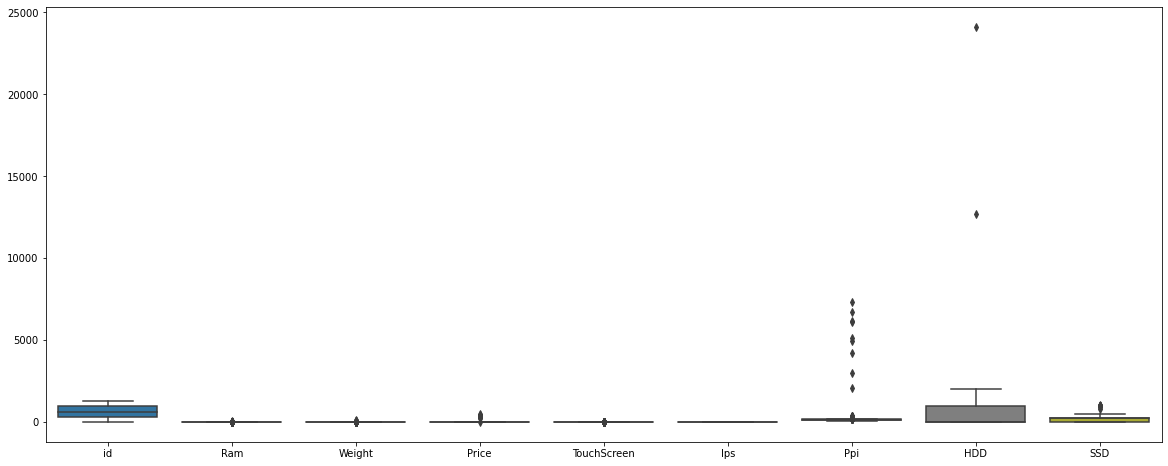

In [549]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df, orient="v")

Para entrenar un modelo de regresión todas las variables de entrada (features) deben ser numéricas. Con ayuda de los expertos, se seleccionan las variables numéricas que se consideran más importantes para la estimación de la variable objetivo (target) `Price`.

Hay variables booleanas que deberían influir en el precio de una laptop como Ips pero para este modelo no parece aplicar.
[Aquí se habla de eso](https://towardsdatascience.com/machine-learning-102-logistic-regression-9e6dc2807772)

In [550]:
features = ['Ram', 'Weight', 'SSD','TouchScreen','Ips','HDD','Ppi']

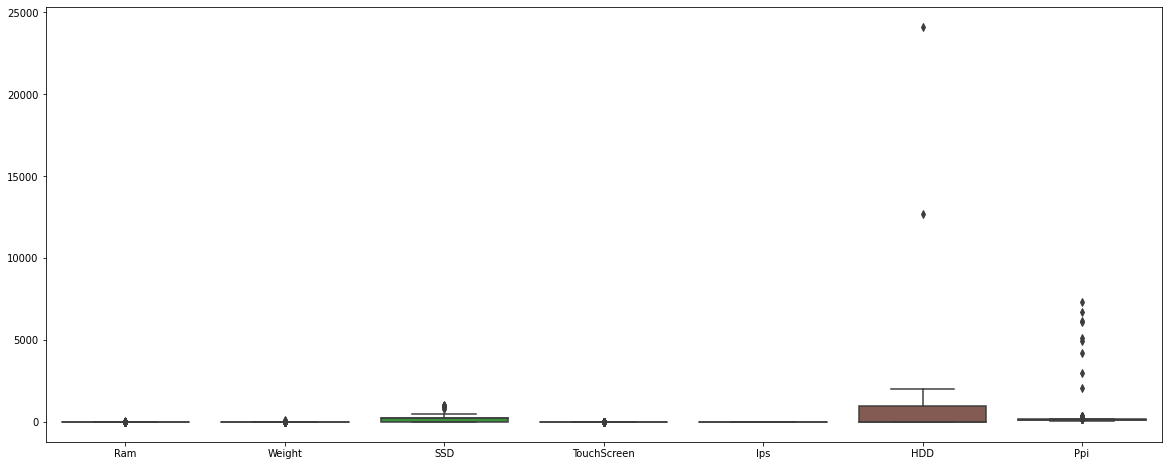

In [551]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df[features], orient="v")

In [552]:
df[['Price'] + features].isnull().sum() / df.shape[0]

Price          0.012336
Ram            0.000000
Weight         0.018914
SSD            0.000000
TouchScreen    0.000000
Ips            0.000000
HDD            0.013158
Ppi            0.009868
dtype: float64

In [553]:
df.loc[df.duplicated(subset=features, keep=False)].sort_values(by=features).head(6)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
546,1126,Lenovo,2 in 1 Convertible,4,0.690,10.147262,1,1,224.173809,Other Intel Processor,0.0,0,Intel,Windows
930,1082,Lenovo,&&2 in 1 Convertible,4,0.690,10.446778,1,1,224.173809,Other Intel Processor,0.0,0,Intel,Windows
181,959,Acer,2 in 1 Convertible,4,1.250,9.939140,1,1,135.094211,Other Intel Processor,0.0,0,Intel,Others
1016,619,Acer,2 in 1 Convertible,4,1.250,9.913097,1,1,135.094211,Other Intel Processor,0.0,0,Intel,Others
373,457,Microsoft,Ultrabook,4,1.252,10.872255,1,0,200.842560,Other Intel Processor,0.0,128,Intel,Windows
502,70,Microsoft,Ultrabook,4,1.252,10.968576,1,0,200.842560,Intel Core i5,0.0,128,Intel,Windows


In [554]:
duplicated_rows = df.loc[df.duplicated(subset = features, keep = False)].shape[0]
duplicated_rows

542

In [555]:
print('Duplicates %:', (duplicated_rows / df.shape[0]))

Duplicates %: 0.4457236842105263


In [556]:
df.loc[df.duplicated(subset = features+['Price'], keep = False)].sort_values(by=features).head(6)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
128,645,Lenovo,Notebook,4,1.43,9.588689,0,0,111.935204,Other Intel Processor,0.0,0,Intel,Windows
1096,645,Lenovo,Notebook,4,1.43,9.588689,0,0,111.935204,Other Intel Processor,0.0,0,Intel,Windows
395,212,HP,Notebook,4,2.10,9.830633,0,0,141.211998,Intel Core i3,500.0,0,Intel,Others
999,101,HP,Notebook,4,2.10,9.830633,0,0,141.211998,AMD Processor,500.0,0,AMD,Windows
422,884,Dell,&&Notebook,4,2.20,9.886358,0,0,100.454670,Other Intel Processor,500.0,0,Intel,Windows
622,1172,Asus,Notebook,4,2.20,9.886358,0,0,100.454670,Other Intel Processor,500.0,0,Intel,Windows


In [557]:
duplicated_rows = df.loc[df.duplicated(subset = features + ['Price'], keep = False)].shape[0]
duplicated_rows

20

In [558]:
print('Duplicates %:', (duplicated_rows / df.shape[0]))

Duplicates %: 0.01644736842105263


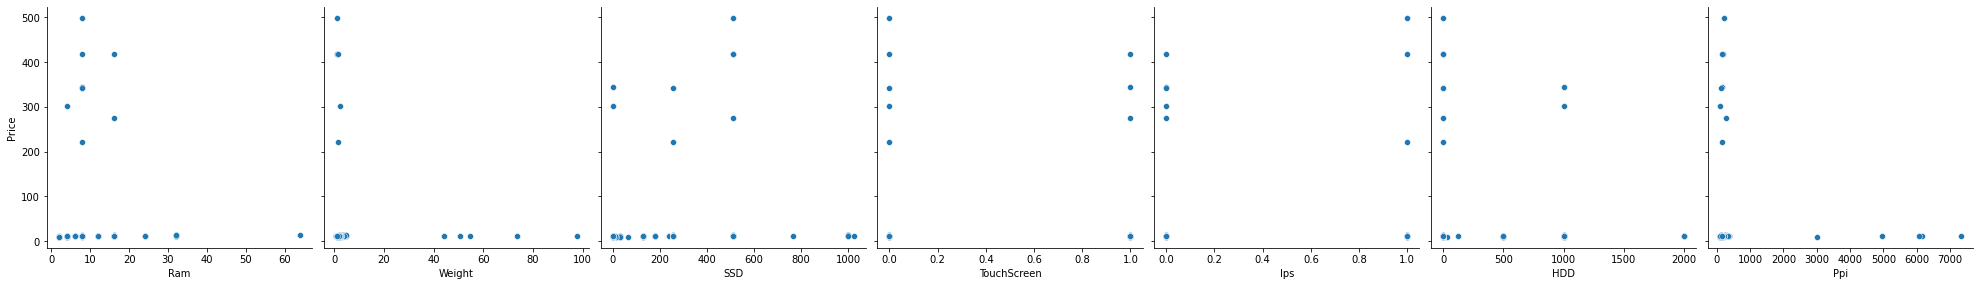

In [559]:
sns.pairplot(df, height = 4, y_vars = 'Price', x_vars = features, kind = 'scatter')

<Axes: >

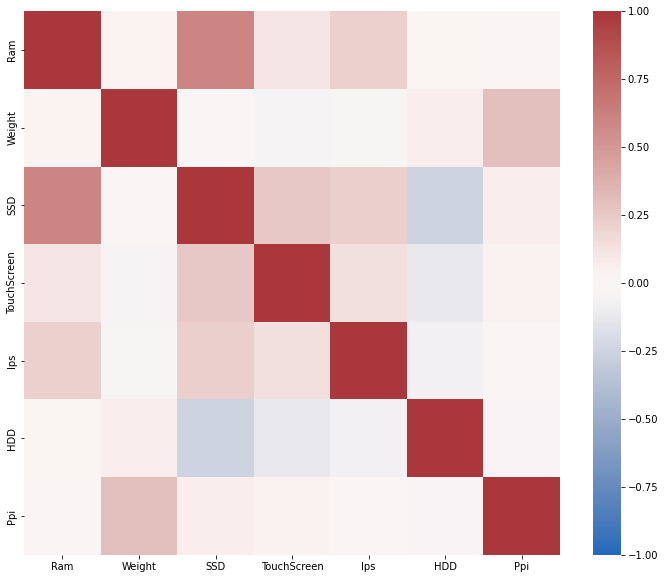

In [560]:
plt.figure(figsize = (12, 10))
sns.heatmap(df[features].corr(), cmap = 'vlag', vmin = -1, vmax = 1)

## 2. Preparación de datos

In [561]:
df.shape

(1216, 14)

In [562]:
df = df.dropna(subset = ['Price'] + features)

In [563]:
df.drop_duplicates(subset = features , inplace=True)

C:\Users\juanm\AppData\Local\Temp\ipykernel_7140\4032658304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset = features , inplace=True)


In [564]:
df.shape

(813, 14)

In [565]:
df[['Price'] + features].isnull().sum() / df.shape[0]

Price          0.0
Ram            0.0
Weight         0.0
SSD            0.0
TouchScreen    0.0
Ips            0.0
HDD            0.0
Ppi            0.0
dtype: float64

In [566]:
df.Price.describe()

count    813.000000
mean      12.266245
std       23.500784
min        9.134616
25%       10.466285
50%       10.964896
75%       11.395541
max      499.766079
Name: Price, dtype: float64

In [567]:
df.Price.unique()

array([ 10.08480861,  10.56311104,  11.06480418,  10.97771698,
        11.55063273,  11.01872094,   9.83063295,  11.23748812,
         9.26886585,  10.83096982,  11.12075716,  10.3368635 ,
        11.14491104,   9.85888341,  11.05642892,  11.54031804,
        10.91384551,  10.45099374,  11.51192496,   9.66929317,
        10.65892197,  10.10461124,  11.41394456,  10.81276508,
        11.10565954,  11.47054726,  11.73730601,  11.13017638,
        11.21835895,  10.349205  ,  10.5108023 ,  11.55778513,
        10.7406    ,  10.97861739,  10.34990418,  10.77684406,
        11.57295735,  11.0222083 ,  11.77899608,  11.18267988,
        11.54754948,  12.58788256,  11.73261217,  10.46628456,
        10.55758617,  11.79920696,   9.99658438,  10.5344678 ,
        10.90898405,  11.219074  ,   9.77161878,  11.11838843,
        10.59431336,  10.52521177,  12.00593479,  10.69578118,
        11.3582826 ,  10.76565826,  11.26721724,  11.41335615,
        11.02307825,  11.00261819,  10.77350144,  11.51

AttributeError: Rectangle.set() got an unexpected keyword argument 'h'

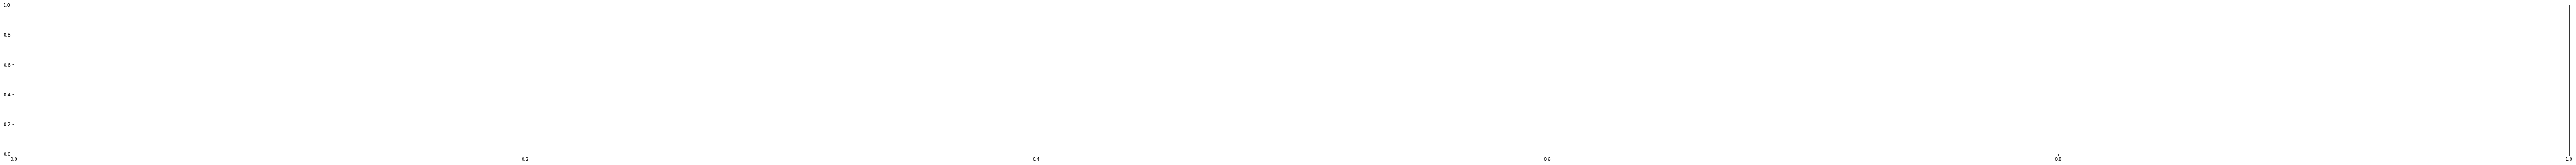

In [568]:
plt.figure(figsize=(100, 6))
sns.countplot(h='Price', data=df)
plt.show()

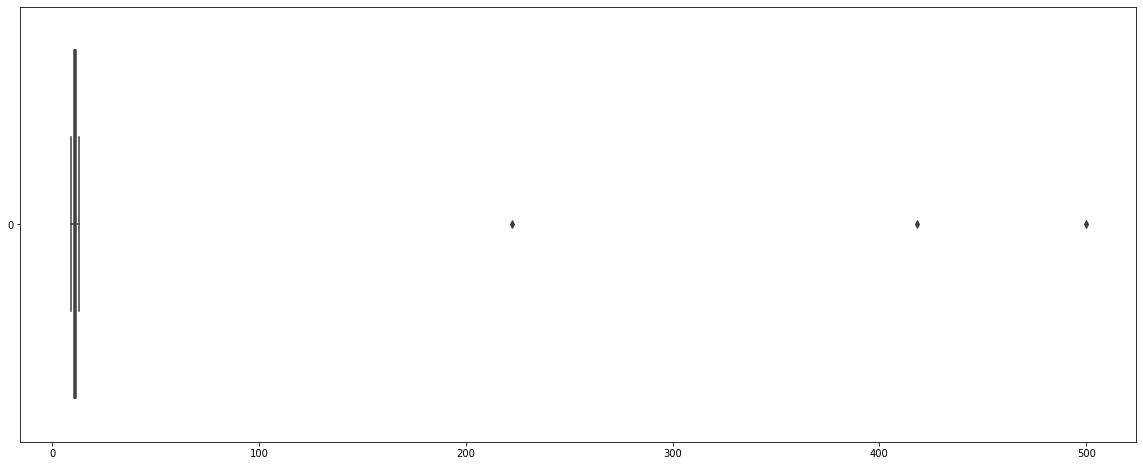

In [569]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df['Price'], orient="h")

## 3. Particionamiento del conjunto de datos en entrenamiento y prueba

In [570]:
X_train, X_test, y_train, y_test = train_test_split(df[features],df['Price'], test_size=0.35, random_state=1)

In [571]:
X_train.shape, y_train.shape

((528, 7), (528,))

In [572]:
X_test.shape, y_test.shape  

((285, 7), (285,))

## 4. Entrenamiento de un primer modelo de regresión lineal


In [573]:
regression= LinearRegression()  

In [574]:
regression.fit(X_train, y_train)

LinearRegression()

## 5. Interpretación de los coeficientes y del intercepto

In [575]:
pd.DataFrame({'features': features, 'coef': regression.coef_})  

,features,coef
0,Ram,0.034354
1,Weight,-0.016399
2,SSD,0.001157
3,TouchScreen,-0.844499
4,Ips,1.377231
5,HDD,-0.000529
6,Ppi,0.002615


In [576]:
regression.intercept_

10.33438069374117

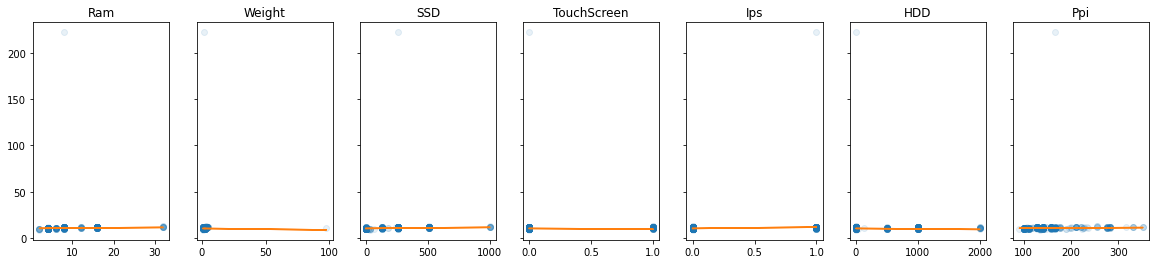

In [577]:
f, axs = plt.subplots(1, len(features), sharey=True, figsize=(20, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

### 4.2. Validación (evaluación) del modelo

**Mean Absolute Error (MAE)**

In [578]:
print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))

Train: 1.1229645176111833
Test: 3.928510835003486


**Root Mean Squeared Error (RMSE)**

In [579]:
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 9.165095308616417
Test: 37.56092837622737


**Análisis del error**

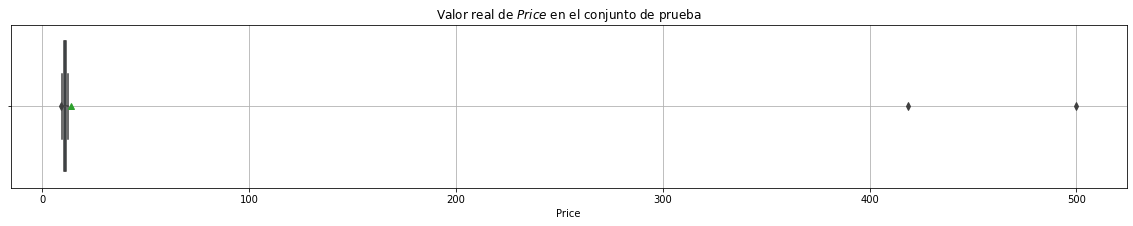

In [580]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real de $\t{Price}$ en el conjunto de prueba")
plt.grid()
plt.show()

In [581]:
y_test.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

count    285.000000
mean      14.054958
std       37.634912
min        9.268866
25%       10.513701
50%       10.962127
75%       11.327361
99%       12.296782
max      499.766079
Name: Price, dtype: float64

## 6. Entrenamiento de un segundo modelo aplicando normalización

In [617]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [583]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [584]:
pd.DataFrame({'features': features, 'coef': pipeline['model'].coef_})

,features,coef
0,Ram,0.184127
1,Weight,-0.069303
2,SSD,0.228135
3,TouchScreen,-0.325719
4,Ips,0.645449
5,HDD,-0.278570
6,Ppi,0.125054


In [585]:
pipeline['model'].intercept_

11.300746326389403

In [586]:
y_train.mean(), y_test.mean()

(11.300746326389403, 14.05495782019425)

In [587]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train)))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test)))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))


MAE:
Train: 1.1229645176111838
Test: 3.928510835003485

RMSE:
Train: 9.165095308616417
Test: 37.56092837622737


### 6.2 Tercer modelo retirando outliner

In [613]:
q1 = y_train.quantile(0.25)
q3 = y_train.quantile(0.75)
iqr = q3 - q1
threshold = q3 + 1.5 * iqr
threshold

12.832560636048104

In [614]:
y_train = y_train.loc[y_train <= threshold]
X_train = X_train.loc[y_train.index]

In [615]:
y_test = y_test.loc[y_test <= threshold]
X_test = X_test.loc[y_test.index]

In [618]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [619]:
pd.DataFrame({'features': features, 'coef': pipeline['model'].coef_})

,features,coef
0,Ram,0.306438
1,Weight,-0.001418
2,SSD,0.185091
3,TouchScreen,-0.020576
4,Ips,0.054797
5,HDD,0.035791
6,Ppi,0.111945


In [620]:
pipeline['model'].intercept_

10.900482450551351

In [621]:
y_train.mean(), y_test.mean()

(10.900482450551351, 10.910132695762204)

In [622]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train)))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test)))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))


MAE:
Train: 0.31891796517697274
Test: 0.36571132078902263

RMSE:
Train: 0.4015136650817049
Test: 0.929005639323369


### 7.1. Colinealidad

<Axes: >

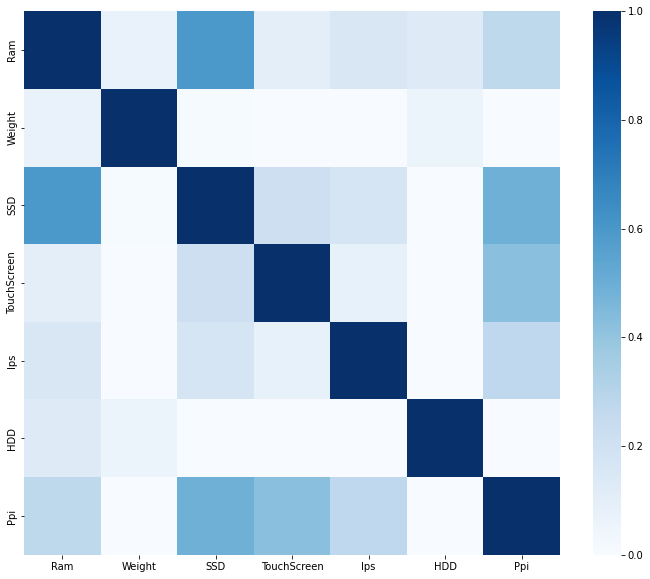

In [588]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), cmap="Blues", vmin=0, vmax=1)

In [589]:
df[features].corr()

,Ram,Weight,SSD,TouchScreen,Ips,HDD,Ppi
Ram,1.000000,0.086093,0.584801,0.080107,0.194629,0.114209,0.022487
Weight,0.086093,1.000000,-0.000695,-0.076060,-0.009712,0.084428,-0.016041
SSD,0.584801,-0.000695,1.000000,0.215027,0.195867,-0.358663,0.067270
TouchScreen,0.080107,-0.076060,0.215027,1.000000,0.087475,-0.187375,0.072239
Ips,0.194629,-0.009712,0.195867,0.087475,1.000000,-0.059860,0.029184
HDD,0.114209,0.084428,-0.358663,-0.187375,-0.059860,1.000000,-0.050878
Ppi,0.022487,-0.016041,0.067270,0.072239,0.029184,-0.050878,1.000000


In [590]:
features2=['Ram','SSD','TouchScreen']

In [591]:
df.Ram.describe()

count    813.000000
mean       9.134071
std        5.700919
min        2.000000
25%        4.000000
50%        8.000000
75%       12.000000
max       64.000000
Name: Ram, dtype: float64

In [592]:
df.SSD.describe()

count     813.000000
mean      207.360394
std       202.882636
min         0.000000
25%         0.000000
50%       256.000000
75%       256.000000
max      1024.000000
Name: SSD, dtype: float64

In [593]:
pipeline.fit(X_train[features2], y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [594]:
pd.DataFrame({'columns': features2, 'coef': pipeline['model'].coef_})

,columns,coef
0,Ram,0.086365
1,SSD,0.531468
2,TouchScreen,-0.217509


In [595]:
pipeline['model'].intercept_

11.300746326389403

In [596]:
print('MAE:')
print('Train:', mean_absolute_error(y_train, pipeline.predict(X_train[features2])))
print('Test:', mean_absolute_error(y_test, pipeline.predict(X_test[features2])))
print('\nRMSE:')
print('Train:', np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features2]))))
print('Test:', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features2]))))

MAE:
Train: 0.926239248444029
Test: 3.7042739101879767

RMSE:
Train: 9.192877685100878
Test: 37.60774405156972


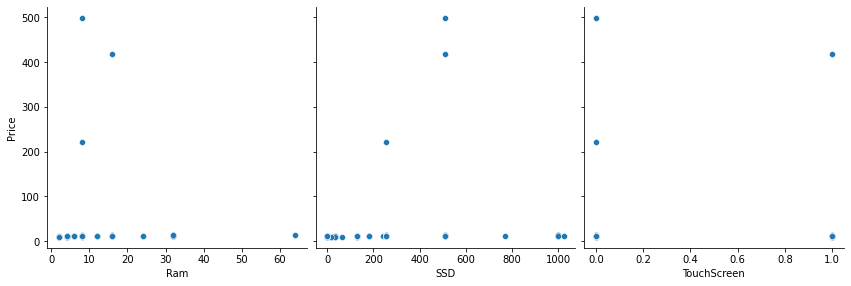

In [597]:
sns.pairplot(df, height = 4, y_vars = 'Price', x_vars = features2, kind = 'scatter')

In [598]:
pipeline = Pipeline(
    [
        ('poly', PolynomialFeatures(degree = 2, include_bias = False)),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]
)

In [599]:
pipeline.fit(X_train[features2], y_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [601]:
pd.DataFrame({'columns': pipeline['poly'].get_feature_names_out(), 'coef': pipeline['model'].coef_})

,columns,coef
0,Ram,0.517472
1,SSD,1.256950
2,TouchScreen,-0.122586
3,Ram^2,-0.522888
4,Ram SSD,0.079843
5,Ram TouchScreen,0.141326
6,SSD^2,-0.850200
7,SSD TouchScreen,-0.129694
8,TouchScreen^2,-0.122586


In [602]:
print('MAE:')
print('Train:', mean_absolute_error(y_train, pipeline.predict(X_train[features2])))
print('Test:', mean_absolute_error(y_test, pipeline.predict(X_test[features2])))
print('\nRMSE:')
print('Train:', np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features2]))))
print('Test:', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features2]))))

MAE:
Train: 0.9833791683286461
Test: 3.7869126583658637

RMSE:
Train: 9.181449978831951
Test: 37.59262103113719


### 7.3. Normalidad de los errores

In [604]:
errors =(pipeline.predict(X_train[features2]) - y_train).values

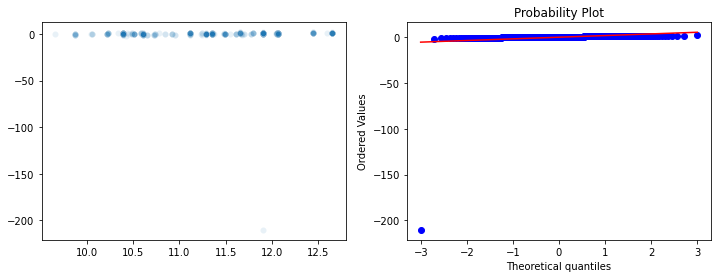

In [605]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

# Dispersión
sns.scatterplot(x = pipeline.predict(X_train[features2]), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist = 'norm', plot = axes[1])

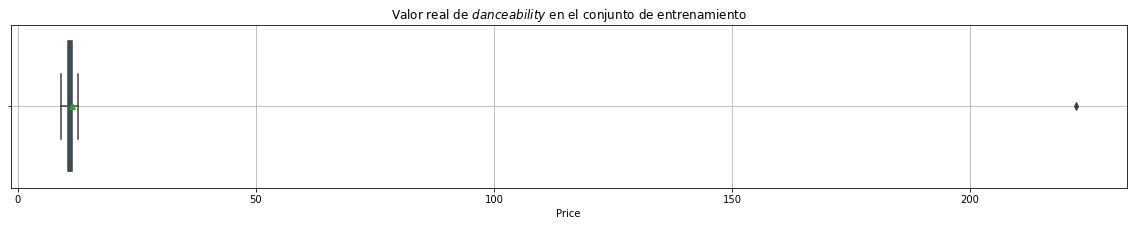

In [606]:
plt.figure(figsize = (20, 3))
sns.boxplot(x = y_train, showmeans = True, orient = 'h')
plt.title('Valor real de $\t{danceability}$ en el conjunto de entrenamiento')
plt.grid()
plt.show()

Valores atípicos

In [607]:
q1 = y_train.quantile(0.25)
q3 = y_train.quantile(0.75)
iqr = q3 - q1
threshold = q3 + 1.5 * iqr
threshold

12.838157847687416

In [608]:
y_train = y_train.loc[y_train <= threshold]
X_train = X_train.loc[y_train.index]

In [609]:
y_test = y_test.loc[y_test <= threshold]
X_test = X_test.loc[y_test.index]

In [610]:
pipeline.fit(X_train[features2], y_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [611]:
pd.DataFrame({'columns': pipeline['poly'].get_feature_names_out(), 'coef': pipeline['model'].coef_})

,columns,coef
0,Ram,6.619650e-01
1,SSD,4.289391e-01
2,TouchScreen,-2.402030e+13
3,Ram^2,-2.598111e-01
4,Ram SSD,-1.809100e-01
5,Ram TouchScreen,-1.989874e-02
6,SSD^2,-1.222244e-01
7,SSD TouchScreen,5.866398e-03
8,TouchScreen^2,2.402030e+13


In [612]:
print('MAE:')
print('Train:', mean_absolute_error(y_train, pipeline.predict(X_train[features2])))
print('Test:', mean_absolute_error(y_test, pipeline.predict(X_test[features2])))
print('\nRMSE:')
print('Train:', np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features2]))))
print('Test:', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features2]))))

MAE:
Train: 0.3044584766743037
Test: 0.29701243836712454

RMSE:
Train: 0.3828890954193682
Test: 0.4089882426838237
